In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import random
import patsy
import sklearn.linear_model as linear

sns.set(style="whitegrid")

import sys
sys.path.append('resources')
import models

# Transformations

At several points in the previous discussions we have hinted at the possibility that transformations might improve the performance and or interpretability of a linear model. In this section, we'll talk about a variety of transformations that accomplish these goals.

## Scaling

Let's review the two jobs that a single $\beta$ does.

Imagine we want to predict some $y$ that has a range of 27 to 89 and we want to model it with an $x$ with the range 345 to 763. Our first observation is that if we have an equation of the form $y = \beta_0 + \beta_1 x$ then $\beta_1$ must *at least* be on the order of 0.#  (1/10th) because $y$ and $x$ differ in magnitude by that much. Therefore, before  before $\beta_1$ does anything else, it must *scale* the value of $x$ to be of the same magnitude of $y$.

It follows that if we start adding features of different magnitudes, some of them in the 000's and some in the 0.000's, then the $\beta$'s must all adjust to the scales of their respective features. This makes it difficult to determine the relative contributions of each predictor (as measured by $\beta_i$).

Additionally, we have the problem of interpreting $\beta_0$, the intercept, when all $x_i$ are zero. It doesn't make any sense for someone to have zero IQ, zero height, zero weight, etc.

Therefore, in order to make coefficients more interpreterable, it is often desirable to transform the variables ahead of time to a common scale. There are two such transformations:

1. subtract each value $x_i$ from its mean $\bar{x_i}$. This creates mean *centered* feature.
2. Take mean centered data and divide through by $x_i$'s standard deviation, $\sigma_{x_i}$. This creates a mean *scaled* feature.

We only apply this transformation to *numerical* features and not dummy variables.

Mean scaling accomplishes two things:

1. Zero is a meaningful value for each $x_i$, the mean value of $x_i$ and thus the intercept $\beta_0$ is interpretable as the value when all $x_i$ are at their mean.
2. Each variable is projected into the standard normal distribution (mean of 0 and standard deviation of 1) so that they're all on the same scale. A unit change is a change of 1 standard deviation in the standard normal distribution.

Mean *centering* accomplishes only the first thing.

However, if you use mean scaling for a *logistic* regression, then "+1" is an entire standard deviation of data. This means that "Divide by 4" won't work and you'll need to figure out what "+1" in real units is in standard deviations. Often it is better to just use mean *centered* data for logistic regression. 

Finally, mean scaling puts the units in "standard units" and mean centering leaves the units in the "natural" units such as feet, square feet, IQ points, etc. This is often desirable.

In [4]:
def mean_scale( df, variable):
    x_bar = df[ variable].mean()
    std = df[ variable].std()
    scaled_variable = (df[ variable] - x_bar) / (2.0 * std) # suggested by Gelman
    df[ variable + "_scaled"] = scaled_variable
    
def mean_center( df, variable):
    x_bar = df[ variable].mean()
    scaled_variable = df[ variable] - x_bar
    df[ variable + "_centered"] = scaled_variable

Back to child IQs...

In [5]:
child_iq = pd.read_csv( "resources/child_iq.tsv", sep="\t")

In [6]:
mean_scale(child_iq, "child_iq")
mean_scale(child_iq, "mom_iq")
mean_scale(child_iq, "mom_age")

In [7]:
child_iq.head()

,child_iq,mom_hs,mom_iq,mom_work,mom_age,child_iq_scaled,mom_iq_scaled,mom_age_scaled
0,65,1,121.117529,4,27,-0.533966,0.703918,0.780114
1,98,1,89.361882,4,25,0.274434,-0.354604,0.409891
2,85,1,115.443165,4,27,-0.044027,0.514772,0.780114
3,83,1,99.449639,3,25,-0.093021,-0.018345,0.409891
4,115,1,92.745710,4,27,0.690882,-0.241810,0.780114


Here's the unscaled model:

In [8]:
model = "child_iq ~ mom_iq + mom_age"
result = models.bootstrap_linear_regression(model, data=child_iq)
print(models.describe_bootstrap_lr(result))

Model: child_iq ~ mom_iq + mom_age
------------  ---------  -----  -------  -----
                                95% BCI
Coefficients             Mean   Lo       Hi
              $\beta_0$  17.60  2.07     37.50
mom_iq        $\beta_1$  0.60   0.51     0.71
mom_age       $\beta_2$  0.39   -0.30    0.94

Metrics       Mean       Lo     Hi
$\sigma$      18.26      17.01  19.21
$R^2$         0.20       0.15   0.27
------------  ---------  -----  -------  -----


Although mom_iq is in the same exact units as child_iq, mom_age and child_iq do not share the same units and they are even of slightly different magnitudes. We know that neither mom_iq nor mom_age can be zero so what is $\beta_0$? This is the same model and the same problem as before.

Here's a completely scaled model:

In [9]:
model = "child_iq_scaled ~ mom_iq_scaled + mom_age_scaled"
result = models.bootstrap_linear_regression(model, data=child_iq)
print(models.describe_bootstrap_lr(result))

Model: child_iq_scaled ~ mom_iq_scaled + mom_age_scaled
--------------  ---------  -----  -------  ----
                                  95% BCI
Coefficients               Mean   Lo       Hi
                $\beta_0$  -0.00  -0.04    0.05
mom_iq_scaled   $\beta_1$  0.44   0.37     0.52
mom_age_scaled  $\beta_2$  0.05   -0.04    0.12

Metrics         Mean       Lo     Hi
$\sigma$        0.45       0.41   0.47
$R^2$           0.20       0.15   0.28
--------------  ---------  -----  -------  ----


How do we interpret this model? At the mean value of mom_iq (=0) and mom_age (=0), child_iq is at *its* mean. If $\beta_0$ had been 6.39 then we would say, "at the mean values of mom_iq and mom_age, we add 6.39 to mean of the child IQ". This gets are the heart of what we've been saying all along: linear models are about estimating means.

One of the strange side effects of mean scaled (and mean centered) models is that you need to calculate and keep all the means around so you know what they are.


It might make a bit more sense to *not* scale the target variable:

In [10]:
model = "child_iq ~ mom_iq_scaled + mom_age_scaled"
result = models.bootstrap_linear_regression(model, data=child_iq)
print(models.describe_bootstrap_lr(result))

Model: child_iq ~ mom_iq_scaled + mom_age_scaled
--------------  ---------  -----  -------  -----
                                  95% BCI
Coefficients               Mean   Lo       Hi
                $\beta_0$  86.80  85.56    88.42
mom_iq_scaled   $\beta_1$  18.11  14.70    21.55
mom_age_scaled  $\beta_2$  2.10   -1.42    5.59

Metrics         Mean       Lo     Hi
$\sigma$        18.26      16.86  19.64
$R^2$           0.20       0.13   0.29
--------------  ---------  -----  -------  -----


This is easier to interpret. When mom_iq and mom_age are at their mean values, the mean child IQ is 86.8. Nice.

It's worth noting that this doesn't improve the *performance* of the model, only the interpretability. This is because we're only considering linear transformations of $x_i$. More about *that* later.

## Natural Baselines

Sometimes it's more natural to center the data against a natural baseline instead of the mean. That is, instead of subtracting the data from the mean, we subtract from a baseline. For example, in the case of IQ, there already exists a baseline: the average IQ is defined as an IQ of 100. You might want to define your coefficients in terms of a baseline IQ of 100. Similarly, if 30 MPG were a Federal mandate or goal, you might want to define a regression dealing with gas mileage in terms of 30 MPG by subtracting it from all the values in the data set.

Let's see.

In [11]:
child_iq["child_iq100"] = child_iq.child_iq - 100
child_iq["mom_iq100"] = child_iq.mom_iq - 100

In [12]:
model = "child_iq100 ~ mom_iq100 + mom_age_scaled"
result = models.bootstrap_linear_regression(model, data=child_iq)
print(models.describe_bootstrap_lr(result))

Model: child_iq100 ~ mom_iq100 + mom_age_scaled
--------------  ---------  ------  -------  ------
                                   95% BCI
Coefficients               Mean    Lo       Hi
                $\beta_0$  -13.20  -14.83   -11.35
mom_iq100       $\beta_1$  0.60    0.50     0.72
mom_age_scaled  $\beta_2$  2.10    -0.58    5.93

Metrics         Mean       Lo      Hi
$\sigma$        18.26      16.75   19.33
$R^2$           0.20       0.14    0.28
--------------  ---------  ------  -------  ------


How do we interpret *this* model? If mom_iq is at the baseline (mom_iq = 0) and mom_age is at the mean (mom_age = 0), then child_iq will be 13.20 points *below* the baseline:

$100 - 13.20 = 86.8$

which is the same number we've gotten before. Again, this just changes the interpretability.

## Save the Parameters

There is one caveat with creating interpretable models using these methods. If you create a regression with transformed variables, the coefficients are now defined in terms of *transformed* variables and you must transform any variables you use the regression equation on. For example, if a new mother came up and wanted us to predict the IQ of her child, we'd need to scale her IQ of, say, 112, with the same mean and standard deviation we used to build the model. Whenever you do any kind of transformation that involves parameters, you should save those parameter values because you will need to use them to make predictions from future data.


## Transformations of Variables

There are other transformations that can be applied to the raw data that don't just improve interpretability: they improve performance. We have already seen the problems we might discover by looking at the residuals of a linear regression. Let's see how we might fix them.

Remember our noiseless synthetic data from the Residuals discussion:

In [13]:
np.random.seed(6734745)

When making the synthetic data, we leave out the intermediate calculation of $x_1^2$ to emphasize that we don't know that it exists.

In [14]:
x1 = np.array([10*np.random.random() for _ in range( 100)])
ys = 1.00 + 2.5 * x1 ** 2 + stats.norm.rvs(0, 30, 100)
data = pd.DataFrame({"y": ys, "x1": x1})

In [15]:
result = models.bootstrap_linear_regression("y ~ x1", data)
print(models.describe_bootstrap_lr(result))

Model: y ~ x1
------------  ---------  ------  -------  ------
                                 95% BCI
Coefficients             Mean    Lo       Hi
              $\beta_0$  -43.12  -55.88   -31.60
x1            $\beta_1$  26.09   24.16    28.17

Metrics       Mean       Lo      Hi
$\sigma$      30.00      24.74   33.72
$R^2$         0.88       0.84    0.91
------------  ---------  ------  -------  ------


The $R^2$ is decent (88%) but the error is high. Let's plot the data:

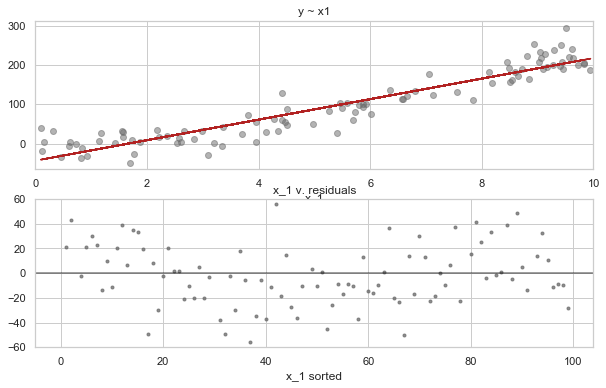

In [16]:
figure = plt.figure(figsize=(10,6))

axes = figure.add_subplot(2, 1, 1)

axes.scatter(data.x1, data.y, color="dimgray", alpha=0.5)
beta = result["coefficients"]
axes.plot(data.x1, [beta[ 0] + beta[ 1] * x for x in data.x1], '-', color="firebrick")
axes.set_title(result[ "formula"])
axes.set_xlim((0, 10))
axes.set_xlabel( "x_1")

axes = figure.add_subplot(2, 1, 2)

keyed_values = sorted(zip(data.x1, result["residuals"]), key=lambda x: x[ 0])

residuals = [x[ 1][ 0] for x in keyed_values]

axes.plot(list(range(0, result[ "n"])), residuals, '.', color="dimgray", alpha=0.75)
axes.axhline(y=0.0, xmin=0, xmax=result[ "n"], c="black", alpha=0.5)
axes.set_title( "x_1 v. residuals")
axes.set_xlabel( "x_1 sorted")
axes.set_ylim((-60.0, 60.0))

plt.show()
plt.close()

There's definitely a "bend" to the residuals which indicates that we're over underestimating at low and high values of $x_1$ and overestimating at medium values of $x_1$. This suggests that a transformation is in order...*which* transformation comes from experience of looking at residuals and at histograms of features.

Since we know what the right answer is, let's see what happens when we create a new feature $x_2 = x_1^2$ and use it in our model:

In [17]:
data["x2"] = data.x1 ** 2

In [18]:
result = models.bootstrap_linear_regression("y ~ x2", data)
print(models.describe_bootstrap_lr(result))

Model: y ~ x2
------------  ---------  -----  -------  ----
                                95% BCI
Coefficients             Mean   Lo       Hi
              $\beta_0$  1.41   -5.25    8.81
x2            $\beta_1$  2.46   2.29     2.62

Metrics       Mean       Lo     Hi
$\sigma$      26.30      22.62  29.80
$R^2$         0.91       0.87   0.94
------------  ---------  -----  -------  ----


This model is much better. The error is smaller, the $R^2$ is larger, and the $\beta_1$ coefficient is almost the "true" value. Let's plot the data and residuals:

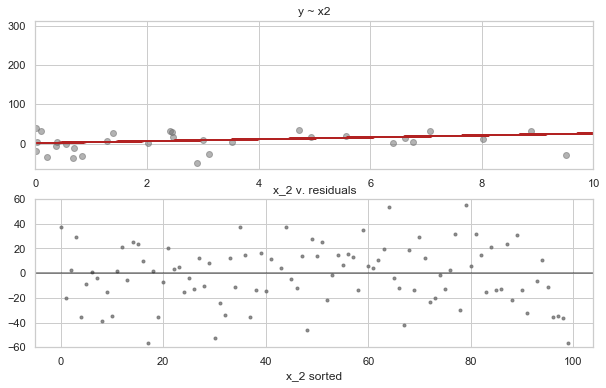

In [19]:
figure = plt.figure(figsize=(10,6))

axes = figure.add_subplot(2, 1, 1)

axes.scatter(data.x2, data.y, color="dimgray", alpha=0.5)
beta = result["coefficients"]
axes.plot(data.x2, [beta[ 0] + beta[ 1] * x for x in data.x2], '-', color="firebrick")
axes.set_title(result[ "formula"])
axes.set_xlim((0, 10))

axes = figure.add_subplot(2, 1, 2)

keyed_values = sorted(zip(data.x2, result["residuals"]), key=lambda x: x[ 0])

residuals = [x[ 1][ 0] for x in keyed_values]

axes.plot(list(range(0, result[ "n"])), residuals, '.', color="dimgray", alpha=0.75)
axes.axhline(y=0.0, xmin=0, xmax=result[ "n"], c="black", alpha=0.5)
axes.set_title( "x_2 v. residuals")
axes.set_xlabel( "x_2 sorted")
axes.set_ylim((-60.0, 60.0))

plt.show()
plt.close()

Perhaps the most surprising thing here is that the model is still linear. "Linear" doesn't mean that you can't have higher degree polynomials:

$y = \beta_0 + \beta_1 x_1^2 + \beta_2 log(x_2) + \beta_3 \sqrt{x_3} + \epsilon$

It means you can't have:

$y = \beta_0 + \beta_1^{x_1}$

And even the last one isn't completely impossible as we will see. To drive the point home, let's show the model in $y-x_1$-space:

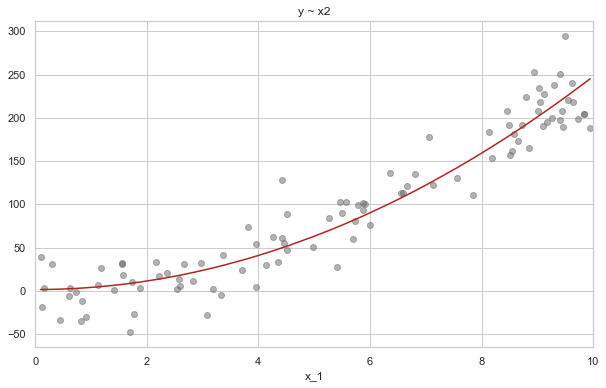

In [20]:
figure = plt.figure(figsize=(10,6))

axes = figure.add_subplot(1, 1, 1)

axes.scatter(data.x1, data.y, color="dimgray", alpha=0.5)
beta = result["coefficients"]

data.sort_values("x1", inplace=True)

axes.plot(data.x1, [beta[ 0] + beta[ 1] * x for x in data.x2], '-', color="firebrick")
axes.set_title(result[ "formula"])
axes.set_xlim((0, 10))
axes.set_xlabel( "x_1")

plt.show()
plt.close()

The challenge will be determining what transformation to use. There are really a fairly limited number and they tend to be related to the mathematical distribution of the data or the process under consideration. Think about what it might mean that the effect is on the *square* of the variable, say, age. Similarly, because earnings or income are often exponentially distributed, it is common to use the square-root, reciprocal, or log of earnings instead of raw earnings. The kind of transformation you try may tie back to your EDA of the variables.

Below is a table of the $x$ and $y$ on a linear effect, $\beta=2$, multiplied by either $x^2$ or $x^{1/2}$:

| $x$ | $x^2$ | $y$ | $x^{1/2}$ | $y$ |
|-----|-------|-----|-----------|-----|
| 0 | 0 | 0 | 0 | 0 |
| 1 | 1 | 2 | 1 | 2 |
| 2 | 4 | 8 | 1.4 | 2.8 |
| 3 | 9 | 18 | 1.7 | 3.4 |

This demonstrates how we can have non-linear effects in $x$ that are really linear in some transformation of $x$. The problem is identifying the transformation of $x$ to use in your model.

In the case of $x^2$, we can see that an increase of $x$ from 0 to 1, leads to a $y$ of 2. However, if we increase $x$ from 1 to 2, the effect on $y$ is to increase to 8 which is substantial more than 2 (6 to be exact). In $x$, this is "increasing returns". If we increase $x$ from 2 to 3, the effect on $y$ is to increase to $18$...by 10. This is a non-linear effect in $x$ and $y$ but linear in $x^2$. In order to model it, we square $x$.

We can see the opposite in the case of $x^{1/2}$. As $x$ increases from 0 to 1, the increase in $y$ is 2 but when we increase $x$ from 1 to 2, $y$ goes from 2 to 2.8...an increase of only 0.8. In $x$, this is "decreasing returns". Similarly, when $x$ increases from 2 to 3, there's an increase in $y$ to 3.4 which is an increase of only 0.6. In order to model it, we take the square root of $x$.

## Numerical to Categorical

When it comes to transformations between numeric and categorical variables, the suggested practice is to deal with numeric variables if possible because you can extract more information from them. This is often at the level of measurement though (when you are recording data) rather than at the point of data transformation. For example, it is more informative and your model may be better if you measure handedness on a scale from 0 to 10 rather than as a binary "left or right". It is usually better to model something as percent correct/successful/voted than pass/fail.

However, there are times when only a categorical variable (or factor) will do. If you coded the US States and the District of Columbia as an integer from 1 to 51, what would a coefficient for this variable even mean? And even if you have a continuous variable sometimes a discretization permits you to model non-linearities.

One exception is that you may need to discretize a variable in order to handle some non-linearities. For example, imagine something depends in a non-linear way on `age`: younger and older people are "for" something ($\beta_{age} > 0$) but middle aged people are against it ($\beta_{age} < 0$). 

If you used numeric `age` in your model, you would get a single value for the coefficient...perhaps even something near zero. If you used categorical age variables (a dummy for each category), you could get a positive coefficient on `age19-29`, a negative one on `age29-49` and a positive one on `age49+`.

## Interaction Terms

We have already mentioned the possibility of including interaction terms in models. When you do you include them? The usual answer is domain knowledge. Sometimes interaction terms fall naturally out of the problem such as when you have height, width, and length. The interaction of these terms is volume.

Otherwise, you can identify variables with "large" effects and then include interaction terms. Although domain theory may indicate that terms with smaller effects interact with each other, it's unlikely that you'll be able to model it. An interaction effect can't be stronger than the main effect. Although it *might* make sense to model only the interaction effect.

Categorical variables are also a source of interaction terms but you need to be aware of the underlying support for the interaction. If you don't have enough observations of that particular--more specific--case, the estimate of the coefficient will probably not be any "good".

## Linear Models of Non-Linear Data

Linear models also imply a additivity/linearity assumption has been violated. In these cases, we can often perform a transformation that results in data that satisfies the assumptions. Taking logarithms generally permit you to model non-linear relationships. 

Consider the following:

$log( y) = \beta_0 + \beta_1 x_1 + \dots + \beta_n x_n$

if you exponentiate this equation you get:

$y = e^{\beta_0 + \beta_1 x_1 + \dots + \beta_n x_n}$

$y = B_0 + B_1^{X_1} + ... B_n^{X_n}$

where $B_0 = e^{\beta_0}$. In this case, each $B_i$ can be interpreted (if you use natural log) as the percent difference in $log( y)$ between groups that differ by one unit of $x_i$.

If you start the other way:

$y = \beta_1^{x_1} \times \dots \times \beta_n^{x_n}$

then taking the log of both sides yields:

$log( y) = log( x_0) + \beta_1 log( x_1) + \dots + \beta_n log( x_n)$.

In this case, the various $\beta_i$ are interpretable as *elasticities* or the percent change in y that results from a 1% change in $x_i$.


## Building Linear Models

Where does this all leave us? What are the steps to building a linear model?

1. Start with all features as suggested by domain knowledge, but...
2. Analyze features for correlations and, of those groups, consider picking the best variable, an average of the variables, or some other transformation (sum, min, max, etc).
3. Transform all categorical variables into one hot encodings but leave one encoding out of the model for each variable. The intercept $\beta_0$ represent all the outcomes that are excluded explicitly. Which one you leave out might depend on the number of observations for each and what you want to do with the model.
4. Examine the residuals and EDA of the features and refer back to domain knowledge to see if any transformations are warranted including converting numerical variables into discrete, categorical variables.



## Step-wise Regression and Data Dredging

As we already mentioned, finding the best subset of features out of a set of variables is NP-hard. Nevertheless, there are heuristics for so-called "Step-wise Regression". To a certain extent, we have been describing a heuristic driven form of manual Step-wise regression that starts with a "all variables in" initial model and then seeks to improve the model by

Step-wise regression is generally frowned up the statistical *cognoscenti* and is associated with "data dredging" and "p-value hacking". The concerns are these:

1. You have collected a bunch of data from an experiment. Your *theory* should tell you the specification for your model. If that model doesn't work, you shouldn't try to tweak it, looking for *some* relationship that fits your theory.
2. As you iterate over models, you are constantly doing statistical significance testing. It's not clear what any of the statistical significance tests for your final model really mean.

We've dodged the last point by using Bayesian inference. We don't have a "multiple comparisons" problem. The evidence supports what the evidence supports to the degree it supports it, based on your prior. As long as you don't go hog wild and use domain knowledge as a guide, you should be alright within the standards of commerce if not science.

And that's really germane to the first point. This is data science but it's not really science *per se*. We're not trying to build and validate a large body of knowledge. We want to know what our customer life time value is. This goes to the Blomberg and Gelman discussion.

It's up to you to not mislead yourself or organization by making tenuous connections in your data, leading to the loss of revenue at best and lives at worst. It behooves all of us to use the tools wisely or someone will take them away from us.

## Assumptions of the Linear Model

We've talked about the assumptions of the linear model but let's bring them all into one place. Classical linear regression has a number of assumptions. We follow Gelman's advice and list them in their order of importance:

1. Validity
2. Additivity and Linearity
3. Independence of errors
4. Equal variance of errors
5. Normality of errors

*Validity* is the most important factor. Reasonably, it is the most important factor in any model building. Since it is possible to find spurious correlations between any number of variables so each variable should have some reason for being included in the model.

Validity is slightly broader than this, however. It also means that if we want to apply our model to underprivileged youths, the original model should not be constructed from data for all youths. Similarly, if we want to apply a model of health and fitness to the general population, it should probably not be built upon data from patients at risk for heart disease.

*Additivity* is important because, well, we are using an additive model. The same is true of *linearity*. But we can apply transformations to get us back into compliance.

*Independence of errors* assumes that errors in prediction are not correlated. We have mentioned this before, what we are saying is that our data should be either independently and identically distributed or, a slightly weaker condition, they are exchangeable. It's easy to think how this might be violated in our child IQ problem: what if more than one child from the same mother is included? 

*Equal variance of errors* (residuals) is the assumption that the variance, $\epsilon_i \sim N(0, \sigma)$, is the same for all i. The technical term for this is *homoskedacity*. The opposite (and undesirable) condition is *heteroskedacity*. We saw this in the Residuals section. Gelman dismisses this as not a very big problem because it does not affect the estimation of $\beta$.

*Normality of errors* (residuals) is something that people often wring their hands about and Gelman says this is the least important. While it might affect our ability to predict (and here it might actually be important to someone), it doesn't affect our ability to form a model, to discover the effects that are $\beta$.

What does a failure of normality mean? It means ability to calculate error bounds is compromised but we have the Bootstrap to estimate credible intervals for any estimate we want to make.